In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import re

# --- Tokenization ---
regex = r"(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"

class SMILESTokenizer:
    def __init__(self):
        self.token2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2token = ['<PAD>', '<UNK>']

    def tokenize(self, smiles):
        return re.findall(regex, smiles)

    def build_vocab(self, smiles_list):
        tokens = set()
        for smi in smiles_list:
            tokens.update(self.tokenize(smi))
        for tok in sorted(tokens):
            if tok not in self.token2idx:
                self.token2idx[tok] = len(self.idx2token)
                self.idx2token.append(tok)

    def encode(self, tokens):
        return [self.token2idx.get(tok, 1) for tok in tokens]

    def decode(self, indices):
        return [self.idx2token[i] for i in indices]

    def detokenize(self, tokens):
        return ''.join(tokens)

# --- Edit Dataset ---
EDIT_ACTIONS = ['COPY', 'REPLACE', 'DELETE', 'INSERT']
ACTION2IDX = {a: i for i, a in enumerate(EDIT_ACTIONS)}

class EditDataset(Dataset):
    def __init__(self, tokenizer, pairs):
        self.tokenizer = tokenizer
        self.pairs = pairs  # list of (src, tgt)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        src_tokens = self.tokenizer.tokenize(src)
        tgt_tokens = self.tokenizer.tokenize(tgt)

        # Generate labels: one edit max
        actions = ['COPY'] * len(src_tokens)
        token_labels = [0] * len(src_tokens)

        # Find first difference (if any)
        for i in range(min(len(src_tokens), len(tgt_tokens))):
            if src_tokens[i] != tgt_tokens[i]:
                actions[i] = 'REPLACE'
                token_labels[i] = self.tokenizer.token2idx.get(tgt_tokens[i], 1)
                break
        else:
            if len(src_tokens) < len(tgt_tokens):
                actions.append('INSERT')
                token_labels.append(self.tokenizer.token2idx.get(tgt_tokens[-1], 1))
                src_tokens.append('<PAD>')
            elif len(src_tokens) > len(tgt_tokens):
                actions[-1] = 'DELETE'

        input_ids = self.tokenizer.encode(src_tokens)
        action_ids = [ACTION2IDX[a] for a in actions]
        token_labels = token_labels

        return torch.tensor(input_ids), torch.tensor(action_ids), torch.tensor(token_labels)

# --- Model ---
class EditModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.encoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.action_classifier = nn.Linear(hidden_dim * 2, len(EDIT_ACTIONS))
        self.token_predictor = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, x):
        x_embed = self.embedding(x)
        enc_out, _ = self.encoder(x_embed)
        action_logits = self.action_classifier(enc_out)
        token_logits = self.token_predictor(enc_out)
        return action_logits, token_logits

# --- Loss ---
def compute_loss(action_logits, token_logits, action_targets, token_targets):
    action_weights = torch.tensor([0.1, 1.0, 1.0, 1.0])
    action_loss = F.cross_entropy(
        action_logits.view(-1, action_logits.size(-1)), 
        action_targets.view(-1), 
        weight=action_weights
    )

    # Token loss only for REPLACE and INSERT
    mask = (action_targets == ACTION2IDX['REPLACE']) | (action_targets == ACTION2IDX['INSERT'])
    masked_logits = token_logits[mask]
    masked_targets = token_targets[mask]

    token_loss = F.cross_entropy(masked_logits, masked_targets) if masked_targets.numel() > 0 else 0.0
    return action_loss + token_loss

# --- Inference ---
def apply_edits(input_tokens, action_preds, token_preds, tokenizer):
    output = []
    for i, act in enumerate(action_preds):
        if act == ACTION2IDX['COPY']:
            output.append(input_tokens[i])
        elif act == ACTION2IDX['REPLACE']:
            output.append(tokenizer.idx2token[token_preds[i]])
        elif act == ACTION2IDX['DELETE']:
            continue
        elif act == ACTION2IDX['INSERT']:
            output.append(tokenizer.idx2token[token_preds[i]])
            output.append(input_tokens[i])
    return tokenizer.detokenize(output)

def correct_smiles_list(smiles_list, tokenizer, model, device='cpu'):
    model.eval()
    corrected_smiles = []

    with torch.no_grad():
        for smiles in smiles_list:
            tokens = tokenizer.tokenize(smiles)
            input_ids = torch.tensor([tokenizer.encode(tokens)], dtype=torch.long).to(device)

            action_logits, token_logits = model(input_ids)

            action_preds = action_logits.argmax(dim=-1)[0].cpu().tolist()
            token_preds = token_logits.argmax(dim=-1)[0].cpu().tolist()

            corrected = apply_edits(tokens, action_preds, token_preds, tokenizer)
            corrected_smiles.append(corrected)

    return corrected_smiles

In [1]:
import numpy as np
import pandas as pd
import random
import string

TRAIN_SIZE = 20000

random.seed(42)

rng = np.random.default_rng(42)

train_data = pd.read_csv('clean_train.csv')
test_data = pd.read_csv('final_test_data80.csv')

combined_smiles = pd.concat([train_data['SMILES'], test_data['SMILES']])
clean_smiles = combined_smiles.sample(TRAIN_SIZE, replace=True)

def corrupt(smi):
    error_type = rng.integers(0, 3)

    corrupted = smi
    if error_type == 0:
        i = rng.integers(0, len(corrupted))
        char = random.choice(string.ascii_letters)
        corrupted = corrupted[:i] + char + corrupted[i+1:]
    elif error_type == 1:
        i = rng.integers(0, len(corrupted))
        corrupted = corrupted[:i] + corrupted[i+1:]
    elif error_type == 2:
        i = rng.integers(0, len(corrupted))
        char = random.choice('()#=')
        corrupted = corrupted[:i] + char + corrupted[i+1:]

    return corrupted

noisy_smiles = clean_smiles.apply(corrupt)

In [2]:
from tqdm import tqdm

EPOCHS = 10
BATCH_SIZE = 64

smiles_pairs = list(zip(noisy_smiles, clean_smiles))

tokenizer = SMILESTokenizer()
tokenizer.build_vocab([s for pair in smiles_pairs for s in pair])

dataset = EditDataset(tokenizer, smiles_pairs)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

model = EditModel(vocab_size=len(tokenizer.idx2token))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    model.train()
    for input_batch, action_batch, token_batch in tqdm(dataloader):
        input_batch = nn.utils.rnn.pad_sequence(input_batch, batch_first=True)
        action_batch = nn.utils.rnn.pad_sequence(action_batch, batch_first=True)
        token_batch = nn.utils.rnn.pad_sequence(token_batch, batch_first=True)

        action_logits, token_logits = model(input_batch)
        loss = compute_loss(action_logits, token_logits, action_batch, token_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} loss: {loss.item():.4f}")


NameError: name 'SMILESTokenizer' is not defined

In [8]:
broken_data = pd.read_csv('broken_smiles.csv')
smiles_to_fix = broken_data['SMILES']
fixed_smiles = correct_smiles_list(smiles_to_fix, tokenizer, model)

for inp, out in zip(smiles_to_fix, fixed_smiles):
    print(f"Noisy: {inp}\nFixed: {out}")

Noisy: CC(C)MC1=C(C(N=C2NNN=N2)=O)SC(OC)=C1Br
Fixed: CC(C)C1=C(C(N=C2NNN=N2)=O)SC(OC)=C1Br
Noisy: C1CCCCC12C(=O)N(C(NC2=O)=O)=C
Fixed: C1CCCCC12C(=O)N(C(NC2=O)=O)=C
Noisy: C(=O)(C)NC1=CC(=CC=C1=C)OC
Fixed: C(=O)(C)NC1=CC(=CC=C1(C)OC
Noisy: N(C(N=S)CC
Fixed: N(C(N)S)CC
Noisy: C1=CC2(C3C(CC4(C)CmO)(C(=O)CO)CCC4C3CCC2=CC1=O)=O)C
Fixed: C1=CC2(C3C(CC4(C)C()(C(=O)CO)CCC4C3CCC2=CC1=O)=O)C
Noisy: CC(C)C(C(=O)O)NC(=O)C(C(C(C)C)#C)NC(C(C)N)=O
Fixed: CC(C)C(C(=O)O)NC(=O)C(C(C(C)C)CC)NC(C(C)N)=O
Noisy: N1=C(C(=NC=C1)C2=C(#C)C=C(C)C=C2)C=3C=CC(C)=CC=3
Fixed: N1=C(C(=NC=C1)C2=C(SC)C=C(C)C=C2)C=3C=CC(C)=CC=3
Noisy: C=C1=C(O)C(=CC=C1)C(C)=O
Fixed: C(11CC(O)C(=CC=C1)C(C)=O
Noisy: C1(=CC=CC=C1)C(=O)C=CCO)=O
Fixed: C1(=CC=CC=C1)C(=O)C(CC()=O
Noisy: CC(C)CC(=O)NC=1C=C(Cl)r(=CC=1)Cl
Fixed: CC(C)CC(=O)NC=1C=C(Cl)(=CC=1)Cl
Noisy: CC=1(C)C=CC=CC=1C2(C(=O)N(C(N2)=O)C)C=3C=CC=CC=3
Fixed: CC=1CC)C=CC=CC=1C2(C(=O)N(C(N2)=O)C)C=3C=CC=CC=3
Noisy: CCC)C(CC1=CC=CC=C1)N
Fixed: CC()C(CC1=CC=CC=C1)N
Noisy: ClC1=C(Cl)C(

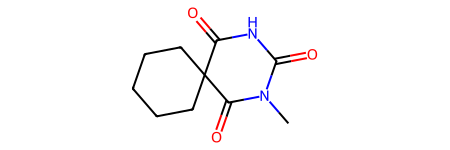

In [39]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import IPythonConsole

MolFromSmiles('C1CCCCC12C(=O)N(C(NC2=O)=O)C', sanitize=False)

In [ ]:
from rdkit.Chem import MolFromSmiles, MolToSmiles

def canonicalize(smiles):
    m = MolFromSmiles(smiles)
    if m is None:
        return None
    else:
        return MolToSmiles(m)

test_data['Can. SMILES'] = test_data['SMILES'].apply(canonicalize)
train_data['Can. SMILES'] = train_data['SMILES'].apply(canonicalize)

2490                         CC(C)(C=NOC(=O)NC)S(=O)(=O)C
10844                    CC(C)C=1N(C([N(](=O)[O-])=NC=1)C
3855     C(CCNCCC1=C2C(=C(O)C=C1)NC(=O)S2)SCCOCC3=C=CC=N3
2106                     C(#N)C(=NNC1=CC=CC=C1Cb)C(OCC)=O
4814      C(=OV(OC=1C=CC=CC=1)C(C2=CC3=CC=C(C=C3C=C2)OC)C
                               ...                       
104                       N#CNC=1N(CCN=1CC=2C=NC(Cl)=CC=2
7803                              C=1C=CC(NNC(OCC)=O)=CC1
282                                   NC(CCCNC(N)=NC(=O)O
1012              FC(F)(F)SC1=CC(C2NC(=N)NC(=N)N=2)=CC=C1
5869             O1C(CCC(=O)O)=nC(=O)C2=CC3=C(CCCC3)C=C12
Name: SMILES, Length: 20000, dtype: object